[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Images with Segment Anything 2 (SAM2)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything-2)

Segment Anything Model 2 (SAM 2) is a foundation model designed to address promptable visual segmentation in both images and videos. The model extends its functionality to video by treating images as single-frame videos. Its design, a simple transformer architecture with streaming memory, enables real-time video processing. A model-in-the-loop data engine, which enhances the model and data through user interaction, was built to collect the SA-V dataset, the largest video segmentation dataset to date. SAM 2, trained on this extensive dataset, delivers robust performance across diverse tasks and visual domains.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-2-paper.jpg)

This notebook is an extension of the official [notebook](https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb) prepared by Meta AI.

## Complementary materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-images-with-sam-2.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-segment-anything-2)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model 2 (SAM2).

[![SAM2 blogpost](https://media.roboflow.com/notebooks/examples/blog-what-is-sam-2.png)](https://blog.roboflow.com/what-is-segment-anything-2)

## Setup

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Install SAM2 and dependencies

In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.31 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [4]:
!pip install -q supervision jupyter_bbox_widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


### Download SAM2 checkpoints

**NOTE:** SAM2 is available in 4 different model sizes ranging from the lightweight "sam2_hiera_tiny" (38.9M parameters) to the more powerful "sam2_hiera_large" (224.4M parameters).

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

### Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [6]:
!mkdir -p {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data

### Imports

In [6]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

**NOTE:** This code enables mixed-precision computing for faster deep learning. It uses bfloat16 for most calculations and, on newer NVIDIA GPUs, leverages TensorFloat-32 (TF32) for certain operations to further boost performance.

In [7]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Load model





In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

## Automated mask generation

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [10]:
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

**NOTE:** OpenCV loads images in BGR format by default, so we convert to RGB for compatibility with the mask generator.

### Output format

`SAM2AutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation

### Advanced automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes.

- `points_per_side` `[int or None]` - the number of points to be sampled
along one side of the image. The total number of points is
`points_per_side**2`. If `None`, `point_grids` must provide explicit
point sampling.
- `points_per_batch` - `[int]` - sets the number of points run simultaneously
by the model. Higher numbers may be faster but use more GPU memory.
- `pred_iou_thresh` `[float]` - a filtering threshold in `[0,1]`, using the
model's predicted mask quality.
- `stability_score_thresh` - `[float]` - a filtering threshold in `[0,1]`, using
the stability of the mask under changes to the cutoff used to binarize
the model's mask predictions.
- `stability_score_offset` - `[float]` - the amount to shift the cutoff when
calculated the stability score.
- `mask_threshold` - `[float]` - threshold for binarizing the mask logits
- `box_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks.
- `crop_n_layers` - `[int]` - if `>0`, mask prediction will be run again on
crops of the image. Sets the number of layers to run, where each
layer has `2**i_layer` number of image crops.
- `crop_nms_thresh` - `[float]` - the box IoU cutoff used by non-maximal
suppression to filter duplicate masks between different crops.
- `crop_overlap_ratio` - `[float]` - sets the degree to which crops overlap.
In the first crop layer, crops will overlap by this fraction of
the image length. Later layers with more crops scale down this overlap.
- `crop_n_points_downscale_factor` - `[int]` - the number of points-per-side
sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`.
- `point_grids` - `[List[np.ndarray] or None]` - a list over explicit grids
of points used for sampling, normalized to `[0,1]`. The nth grid in the
list is used in the nth crop layer. Exclusive with points_per_side.
- `min_mask_region_area` - `[int]` - if `>0`, postprocessing will be applied
to remove disconnected regions and holes in masks with area smaller
than `min_mask_region_area`. Requires opencv.

In [9]:
IMAGE_PATH = f"/content/airfoil with sphere.png"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


In [10]:

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
)

In [ ]:
sam2_result_2 = mask_generator_2.generate(image_rgb)

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

In [ ]:
import cv2
import numpy as np

# 1. Load your binary input mask
input_mask = cv2.imread("/content/air_foil.png", cv2.IMREAD_GRAYSCALE)
input_mask = (input_mask > 127).astype(np.uint8)  # convert to binary (0/1)

# 2. Your list of masks
masks = [
    mask['segmentation']
    for mask in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

# 3. Define IoU function
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# 4. Compute IoU for each predicted mask
ious = [iou(input_mask, m) for m in masks]

# 5. Find the best match
best_index = np.argmax(ious)
best_mask = masks[best_index]
best_iou = ious[best_index]

print(f"Best mask index: {best_index}")
print(f"Best IoU: {best_iou:.4f}")


ID: 0, RGB: [222, 89, 130], Area: 777842 pixels, Num pixels: 777842
ID: 1, RGB: [140, 140, 187], Area: 220346 pixels, Num pixels: 220346
ID: 2, RGB: [140, 140, 187], Area: 138759 pixels, Num pixels: 138759
ID: 3, RGB: [76, 84, 153], Area: 61365 pixels, Num pixels: 61365
ID: 4, RGB: [86, 166, 164], Area: 53786 pixels, Num pixels: 53786
ID: 5, RGB: [86, 166, 164], Area: 53627 pixels, Num pixels: 53627
ID: 6, RGB: [69, 186, 98], Area: 35290 pixels, Num pixels: 35290
ID: 7, RGB: [120, 210, 180], Area: 11745 pixels, Num pixels: 11745
ID: 8, RGB: [235, 136, 210], Area: 7898 pixels, Num pixels: 7898
ID: 9, RGB: [235, 136, 210], Area: 7710 pixels, Num pixels: 7710
ID: 10, RGB: [192, 185, 130], Area: 6403 pixels, Num pixels: 6403
ID: 11, RGB: [192, 185, 130], Area: 6302 pixels, Num pixels: 6302
ID: 12, RGB: [234, 204, 106], Area: 6236 pixels, Num pixels: 6236
ID: 13, RGB: [189, 120, 112], Area: 4971 pixels, Num pixels: 4971
ID: 14, RGB: [189, 120, 112], Area: 4952 pixels, Num pixels: 4952
ID: 1

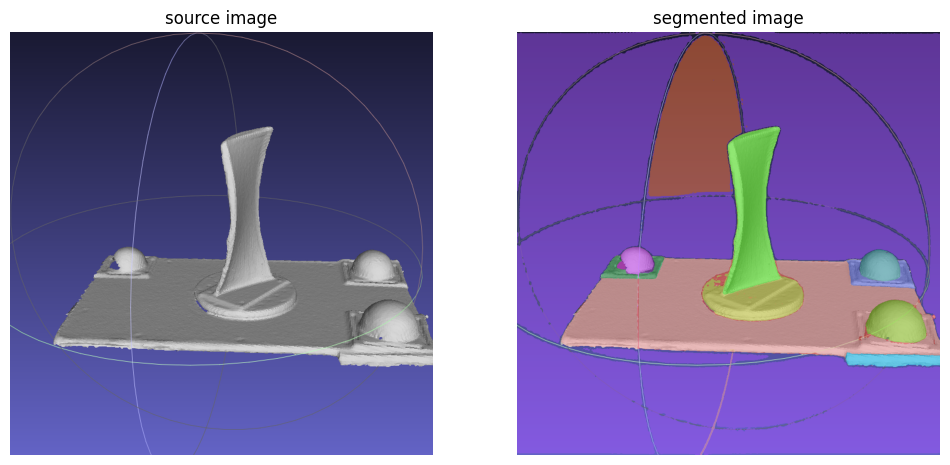

In [36]:
import numpy as np
import json

# Your existing code
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Extract IDs and RGB values
ids_and_colors = []

for idx in range(len(detections)):
    # Get the mask for this detection
    mask = detections.mask[idx]

    # Get the RGB color used for this mask in the annotated image
    mask_pixels = annotated_image[mask]

    if len(mask_pixels) > 0:
        # Get the most common color (should be uniform for each mask)
        unique_colors, counts = np.unique(mask_pixels.reshape(-1, 3), axis=0, return_counts=True)
        most_common_color = unique_colors[counts.argmax()]

        # Get pixel coordinates where mask is True
        pixel_coords = np.argwhere(mask)  # Returns array of [y, x] coordinates

        ids_and_colors.append({
            'id': idx,
            'label': f'segment_{idx}',  # You can customize this label
            'rgb': tuple(int(c) for c in most_common_color),  # Convert to int for JSON
            'area': int(mask.sum()),  # number of pixels in the mask
            'bbox': [float(x) for x in detections.xyxy[idx]],  # [x1, y1, x2, y2]
            'segmented_pixels': pixel_coords.tolist()  # List of [y, x] coordinates
        })

# Display the results
for item in ids_and_colors:
    print(f"ID: {item['id']}, Label: {item['label']}, RGB: {item['rgb']}, Area: {item['area']} pixels")

# Save to JSON file
output_data = {
    'image_path': IMAGE_PATH,
    'image_shape': image_bgr.shape,
    'total_segments': len(ids_and_colors),
    'segments': ids_and_colors
}

with open('/content/data.json', 'w') as f:
    json.dump(output_data, f, indent=2)

print("\nData saved to /content/data.json")

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [34]:
import yaml

# Read the YAML file
with open(r'data.yml', 'r') as f:
    data = yaml.safe_load(f)

# Extract IDs and RGB values
id_color_mapping = {}

for segment in data['segments']:
    segment_id = segment['id']
    rgb_color = tuple(segment['rgb'])  # Convert list to tuple
    id_color_mapping[segment_id] = rgb_color

# Display the mapping
print("ID to RGB Color Mapping:")
print("-" * 40)
for seg_id, rgb in id_color_mapping.items():
    print(f"ID: {seg_id:3d} -> RGB: {rgb}")

# Optionally, create separate lists
ids = list(id_color_mapping.keys())
colors = list(id_color_mapping.values())

print(f"\nTotal segments: {len(id_color_mapping)}")

KeyboardInterrupt: 

ID: 0, RGB: (np.uint8(144), np.uint8(56), np.uint8(98)), Area: 118087 pixels
ID: 1, RGB: (np.uint8(36), np.uint8(68), np.uint8(136)), Area: 50401 pixels
ID: 2, RGB: (np.uint8(36), np.uint8(68), np.uint8(136)), Area: 48697 pixels
ID: 3, RGB: (np.uint8(36), np.uint8(68), np.uint8(136)), Area: 48566 pixels
ID: 4, RGB: (np.uint8(64), np.uint8(128), np.uint8(162)), Area: 46958 pixels
ID: 5, RGB: (np.uint8(133), np.uint8(132), np.uint8(76)), Area: 46228 pixels
ID: 6, RGB: (np.uint8(166), np.uint8(218), np.uint8(148)), Area: 45659 pixels
ID: 7, RGB: (np.uint8(166), np.uint8(218), np.uint8(148)), Area: 45575 pixels
ID: 8, RGB: (np.uint8(166), np.uint8(218), np.uint8(148)), Area: 45335 pixels
ID: 9, RGB: (np.uint8(194), np.uint8(152), np.uint8(144)), Area: 31041 pixels
ID: 10, RGB: (np.uint8(116), np.uint8(128), np.uint8(22)), Area: 30946 pixels
ID: 11, RGB: (np.uint8(194), np.uint8(152), np.uint8(144)), Area: 30782 pixels
ID: 12, RGB: (np.uint8(194), np.uint8(152), np.uint8(144)), Area: 30235 

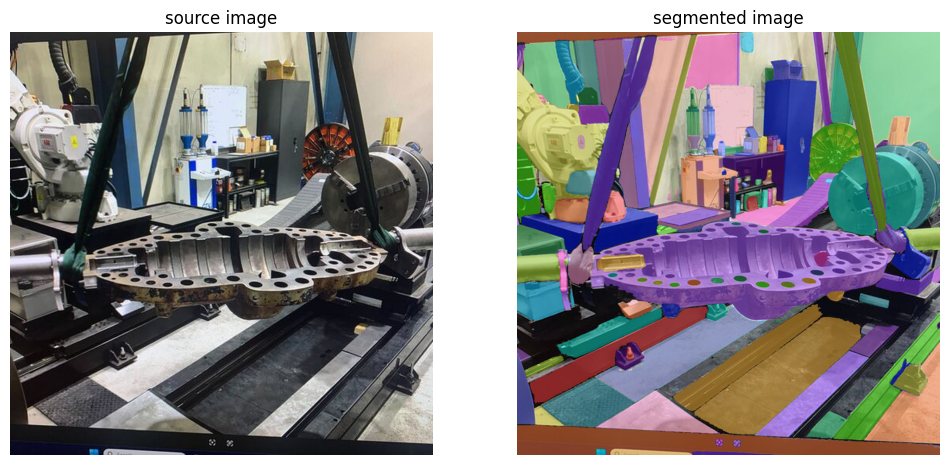

In [37]:
import numpy as np

# Your existing code
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Extract IDs and RGB values
ids_and_colors = []

for idx in range(len(detections)):
    # Get the mask for this detection
    mask = detections.mask[idx]

    # Get the RGB color used for this mask in the annotated image
    # Find pixels where this mask is True
    mask_pixels = annotated_image[mask]

    if len(mask_pixels) > 0:
        # Get the most common color (should be uniform for each mask)
        unique_colors, counts = np.unique(mask_pixels.reshape(-1, 3), axis=0, return_counts=True)
        most_common_color = unique_colors[counts.argmax()]

        ids_and_colors.append({
            'id': idx,
            'rgb': tuple(most_common_color),
            'area': mask.sum(),  # number of pixels in the mask
            'bbox': detections.xyxy[idx]  # bounding box coordinates
        })

# Display the results
for item in ids_and_colors:
    print(f"ID: {item['id']}, RGB: {item['rgb']}, Area: {item['area']} pixels")

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [38]:
from supervision.draw.color import ColorPalette

# Get the color palette used by supervision
color_palette = ColorPalette.DEFAULT

ids_and_colors = []
for idx in range(len(detections)):
    # Get color from the palette
    color = color_palette.by_idx(idx)

    ids_and_colors.append({
        'id': idx,
        'rgb': (color.r, color.g, color.b),
        'bgr': (color.b, color.g, color.r),  # for OpenCV
        'mask': detections.mask[idx],
        'area': detections.mask[idx].sum(),
        'bbox': detections.xyxy[idx]
    })

# Print the mapping
for item in ids_and_colors:
    print(f"Segment ID: {item['id']} -> RGB: {item['rgb']}")

Segment ID: 0 -> RGB: (163, 81, 251)
Segment ID: 1 -> RGB: (255, 64, 64)
Segment ID: 2 -> RGB: (255, 161, 160)
Segment ID: 3 -> RGB: (255, 118, 51)
Segment ID: 4 -> RGB: (255, 182, 51)
Segment ID: 5 -> RGB: (209, 212, 53)
Segment ID: 6 -> RGB: (76, 251, 18)
Segment ID: 7 -> RGB: (148, 207, 26)
Segment ID: 8 -> RGB: (64, 222, 138)
Segment ID: 9 -> RGB: (27, 150, 64)
Segment ID: 10 -> RGB: (0, 214, 193)
Segment ID: 11 -> RGB: (46, 156, 170)
Segment ID: 12 -> RGB: (0, 196, 255)
Segment ID: 13 -> RGB: (54, 71, 151)
Segment ID: 14 -> RGB: (102, 117, 255)
Segment ID: 15 -> RGB: (0, 25, 239)
Segment ID: 16 -> RGB: (134, 58, 255)
Segment ID: 17 -> RGB: (83, 0, 135)
Segment ID: 18 -> RGB: (205, 58, 255)
Segment ID: 19 -> RGB: (255, 151, 202)
Segment ID: 20 -> RGB: (255, 57, 201)
Segment ID: 21 -> RGB: (163, 81, 251)
Segment ID: 22 -> RGB: (255, 64, 64)
Segment ID: 23 -> RGB: (255, 161, 160)
Segment ID: 24 -> RGB: (255, 118, 51)
Segment ID: 25 -> RGB: (255, 182, 51)
Segment ID: 26 -> RGB: (209, 

In [30]:
# Create a filtered detection with only ID 0
mask_0 = detections.mask[0:1]  # Keep as 2D array with shape (1, H, W)
xyxy_0 = detections.xyxy[0:1]  # Keep as 2D array with shape (1, 4)

# Create new Detections object with only ID 0
detections_filtered = sv.Detections(
    xyxy=xyxy_0,
    mask=mask_0
)

# Annotate with only ID 0
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
annotated_image_id0 = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections_filtered)

sv.plot_images_grid(
    images=[image_bgr, annotated_image_id0],
    grid_size=(1, 2),
    titles=['source image', 'segment id=0 only']
)

In [18]:
import matplotlib.pyplot as plt


In [ ]:
import supervision as sv

# Create the mask annotator (as you already did)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Convert SAM output to Supervision detections
detections = sv.Detections.from_sam(sam_result=sam2_result_2)

# Annotate the masks on the original image
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# --- Add ID labels for each segment ---
# You can use the LabelAnnotator to write IDs or text
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

# Create a list of text labels (IDs)
# If you just want to show the index number for each segment:
labels = [f"ID {i}" for i in range(len(detections))]

# Annotate labels on top of the mask-annotated image
annotated_image_with_ids = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

# Plot side-by-side: original, segmented, and labeled
sv.plot_images_grid(
    images=[image_bgr, annotated_image_with_ids],
    grid_size=(1, 2),
    titles=['source image', 'segmented image (with IDs)']
)


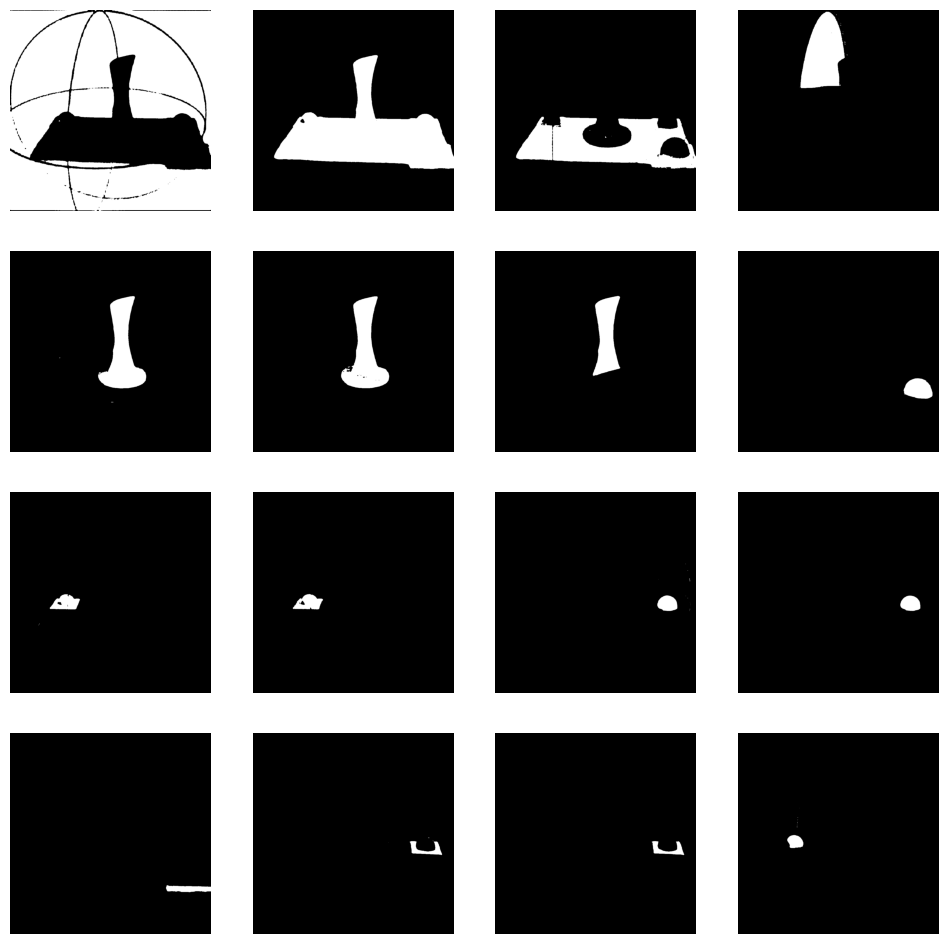

In [46]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks[:16],
    grid_size=(4, 4),
    size=(12, 12)
)

In [47]:
import cv2
import numpy as np

# 1. Load your binary input mask
input_mask = cv2.imread("/content/air_foil.png", cv2.IMREAD_GRAYSCALE)
input_mask = (input_mask > 127).astype(np.uint8)  # convert to binary (0/1)

# 2. Your list of masks
masks = [
    mask['segmentation']
    for mask in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

# 3. Define IoU function
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# 4. Compute IoU for each predicted mask
ious = [iou(input_mask, m) for m in masks]

# 5. Find the best match
best_index = np.argmax(ious)
best_mask = masks[best_index]
best_iou = ious[best_index]

print(f"Best mask index: {best_index}")
print(f"Best IoU: {best_iou:.4f}")


Best mask index: 4
Best IoU: 0.9035


True
✅ Best mask index: 7
✅ Best IoU score: 0.4707


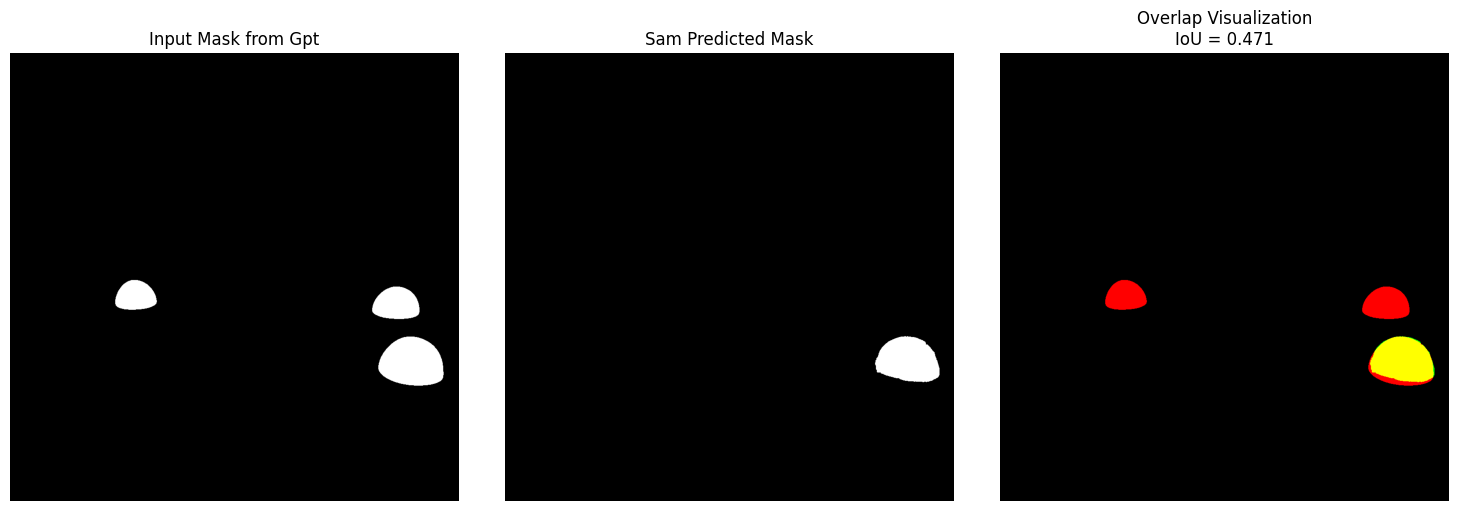

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.path.exists("/content/spheres_3.png"))

# 1. Load input binary mask
input_mask = cv2.imread("/content/spheres_3.png", cv2.IMREAD_GRAYSCALE)
input_mask = (input_mask > 127).astype(np.uint8)

# 2. Get predicted masks (from SAM or SAM2 results)
masks = [
    mask['segmentation']
    for mask in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

# 3. Define IoU function
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# 4. Compare all masks and find the best one
ious = []
for m in masks:
    # resize mask if not same size as input
    if m.shape != input_mask.shape:
        m = cv2.resize(m.astype(np.uint8), (input_mask.shape[1], input_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    ious.append(iou(input_mask, m))

best_index = np.argmax(ious)
best_mask = masks[best_index]
best_iou = ious[best_index]

# 5. Resize best mask for display (if needed)
if best_mask.shape != input_mask.shape:
    best_mask = cv2.resize(best_mask.astype(np.uint8), (input_mask.shape[1], input_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f"✅ Best mask index: {best_index}")
print(f"✅ Best IoU score: {best_iou:.4f}")

# 6. Visualize
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input Mask from Gpt")
plt.imshow(input_mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Sam Predicted Mask")
plt.imshow(best_mask, cmap='gray')
plt.axis('off')

# Create color overlay visualization
overlap = np.zeros((input_mask.shape[0], input_mask.shape[1], 3), dtype=np.uint8)
overlap[input_mask == 1] = [255, 0, 0]   # red for input mask
overlap[best_mask == 1] = [0, 255, 0]    # green for predicted mask
overlap[np.logical_and(input_mask == 1, best_mask == 1)] = [255, 255, 0]  # yellow = overlap

plt.subplot(1,3,3)
plt.title(f"Overlap Visualization\nIoU = {best_iou:.3f}")
plt.imshow(overlap)
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Found 9 masks with IoU >= 0.15
 - Mask 7: IoU = 0.4707
 - Mask 8: IoU = 0.1695
 - Mask 9: IoU = 0.1712
 - Mask 10: IoU = 0.2233
 - Mask 11: IoU = 0.2236
 - Mask 15: IoU = 0.1701
 - Mask 16: IoU = 0.1706
 - Mask 17: IoU = 0.1701
 - Mask 18: IoU = 0.1590


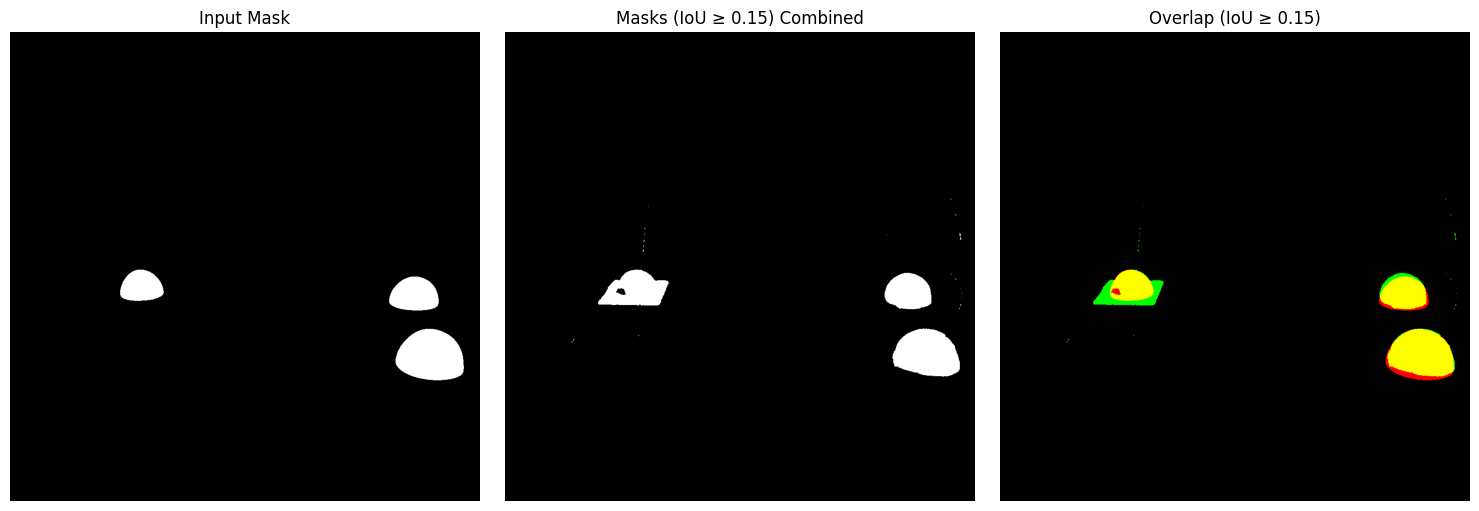

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load input binary mask
input_mask = cv2.imread("/content/spheres_3.png", cv2.IMREAD_GRAYSCALE)
input_mask = (input_mask > 127).astype(np.uint8)

# 2. Get predicted masks (from SAM or SAM2 results)
masks = [
    mask['segmentation']
    for mask in sorted(sam2_result_2, key=lambda x: x['area'], reverse=True)
]

# 3. Define IoU function
def iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

# 4. Compute IoUs for all masks (resize if necessary)
ious = []
resized_masks = []
for m in masks:
    if m.shape != input_mask.shape:
        m = cv2.resize(m.astype(np.uint8), (input_mask.shape[1], input_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    resized_masks.append(m)
    ious.append(iou(input_mask, m))

# 5. Select masks above a threshold
threshold = 0.15 # choose your own threshold
selected_indices = [i for i, score in enumerate(ious) if score >= threshold]

print(f"✅ Found {len(selected_indices)} masks with IoU >= {threshold}")
for i in selected_indices:
    print(f" - Mask {i}: IoU = {ious[i]:.4f}")

# 6. Combine selected masks (optional)
if selected_indices:
    combined_mask = np.zeros_like(input_mask, dtype=np.uint8)
    for i in selected_indices:
        combined_mask = np.logical_or(combined_mask, resized_masks[i])
    combined_mask = combined_mask.astype(np.uint8)
else:
    combined_mask = np.zeros_like(input_mask)

# 7. Visualization
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input Mask GPT")
plt.imshow(input_mask, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title(f"Sam Masks (IoU ≥ {threshold}) Combined")
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')

# Overlap visualization
overlap = np.zeros((*input_mask.shape, 3), dtype=np.uint8)
overlap[input_mask == 1] = [255, 0, 0]       # red = input
overlap[combined_mask == 1] = [0, 255, 0]    # green = combined prediction
overlap[np.logical_and(input_mask == 1, combined_mask == 1)] = [255, 255, 0]  # yellow = overlap

plt.subplot(1,3,3)
plt.title(f"Overlap (IoU ≥ {threshold})")
plt.imshow(overlap)
plt.axis('off')

plt.tight_layout()
plt.show()


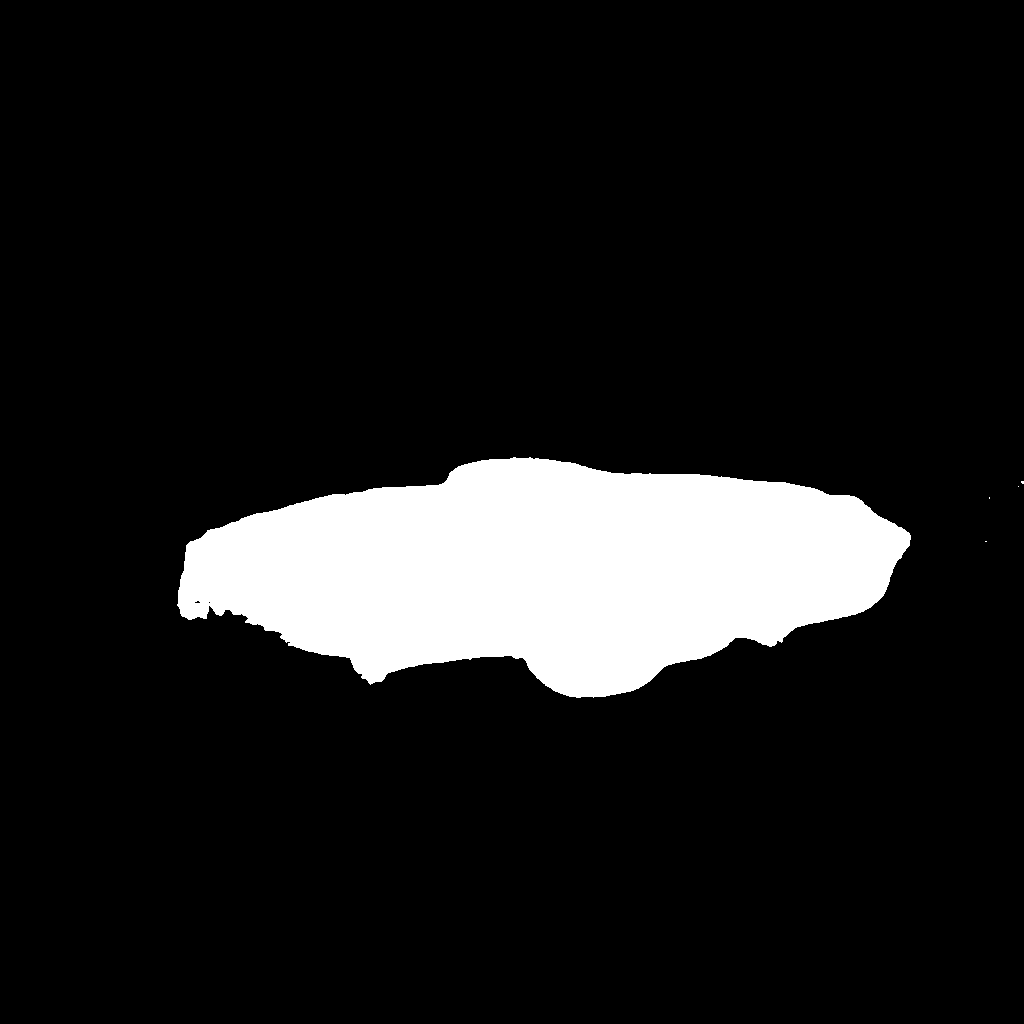

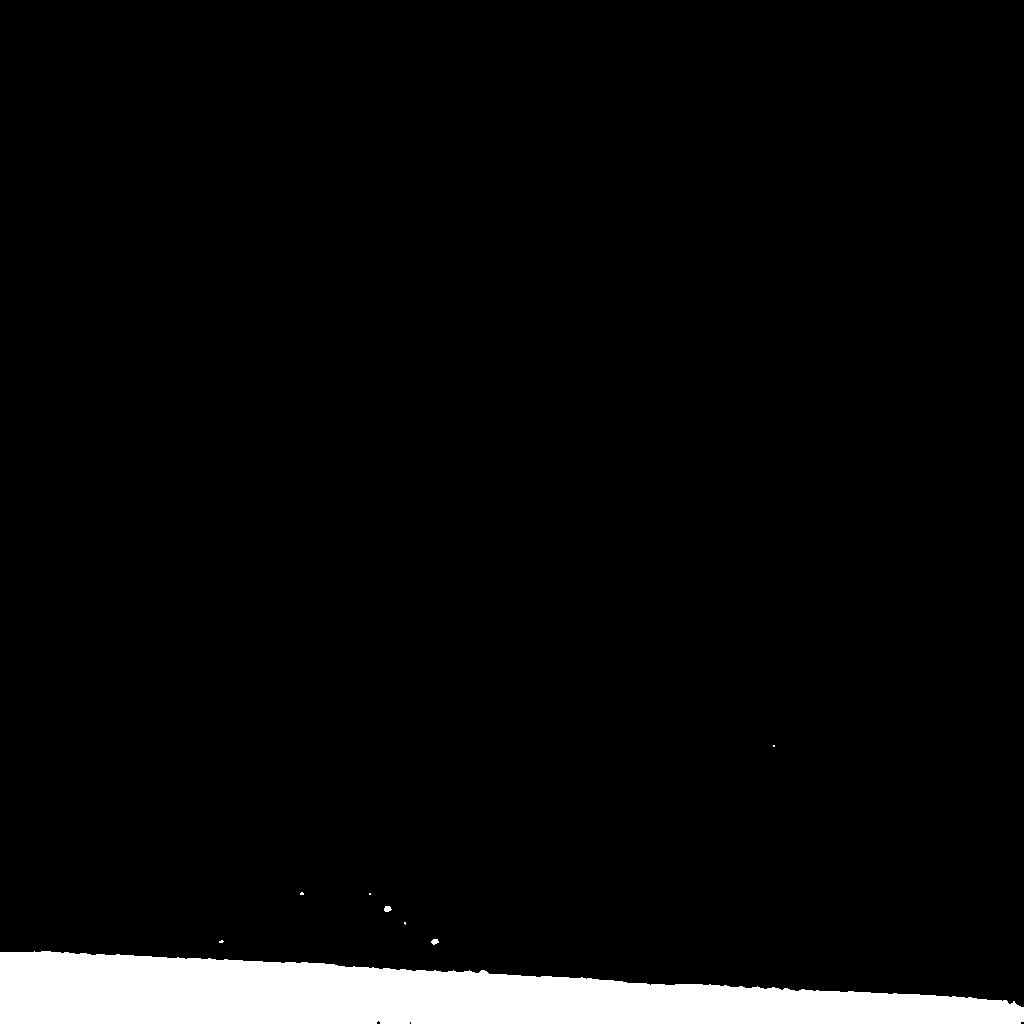

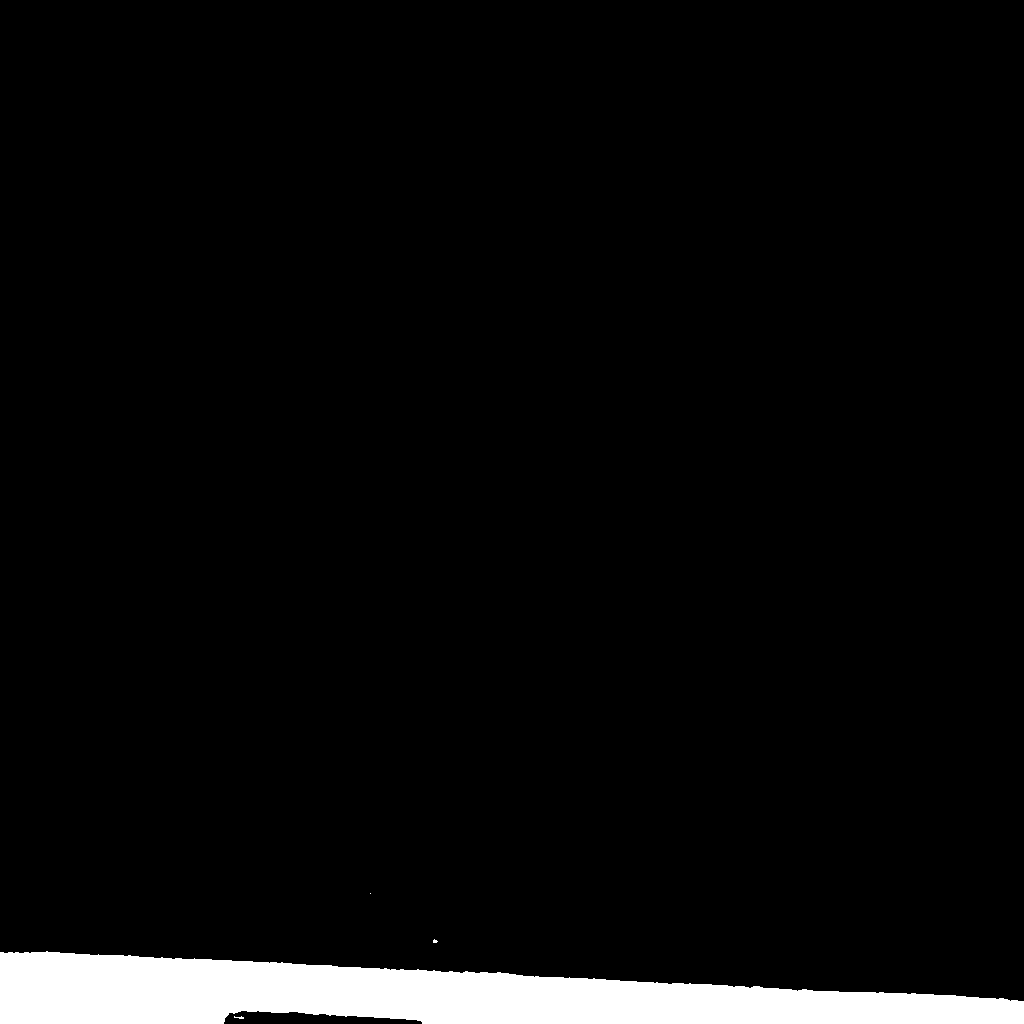

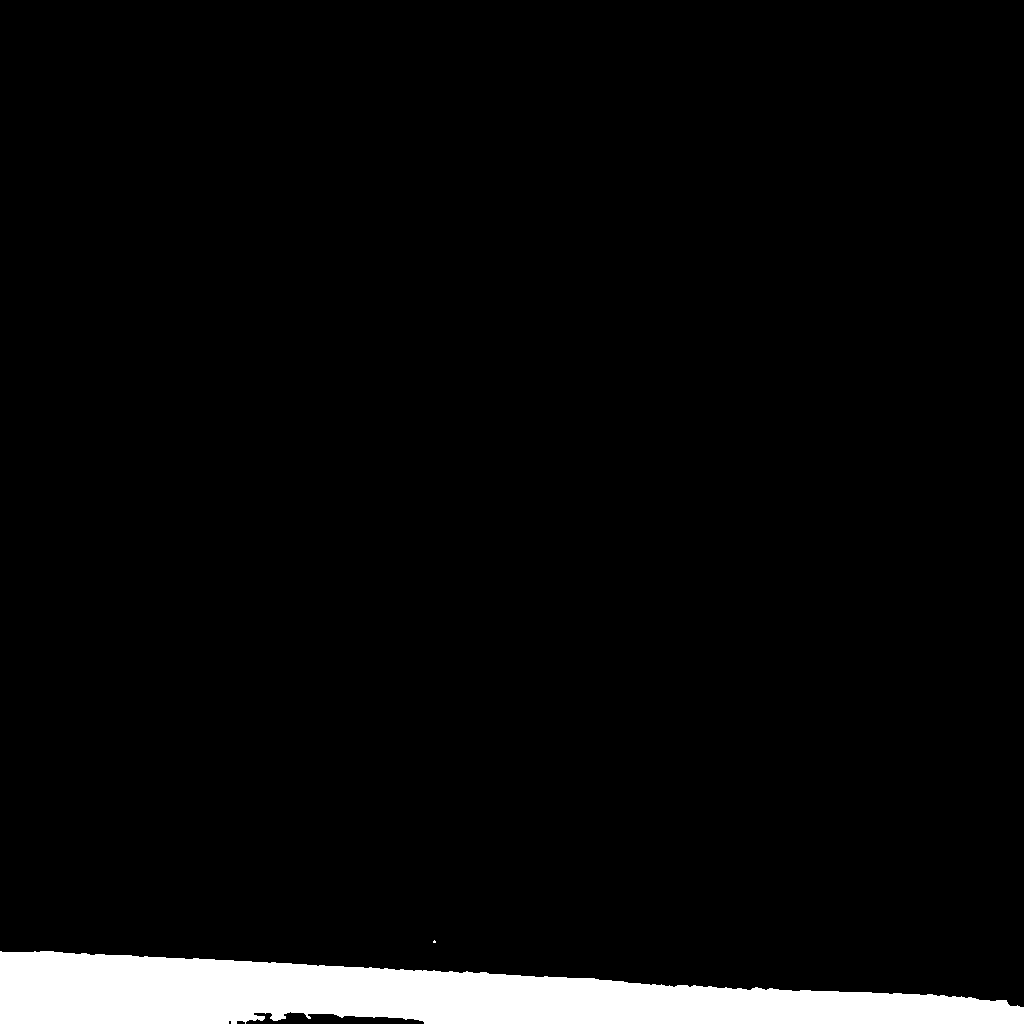

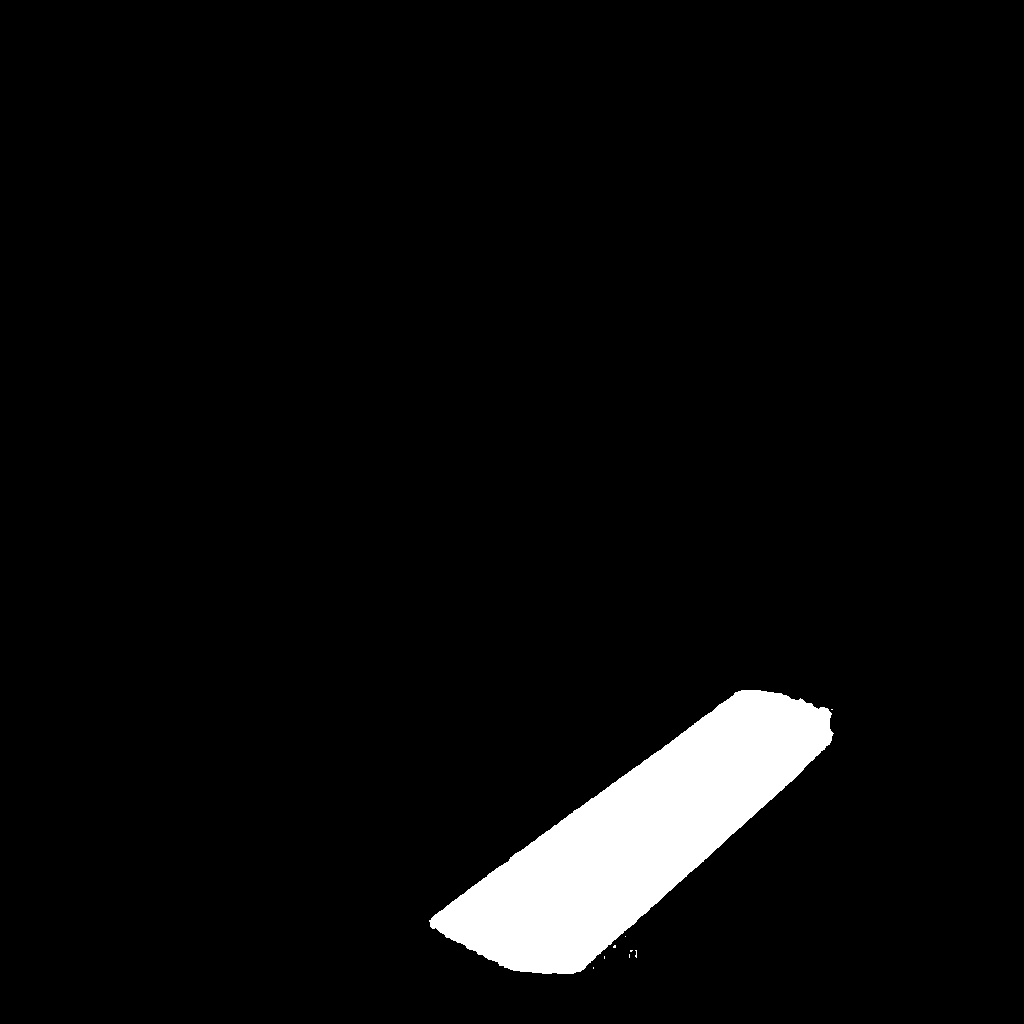

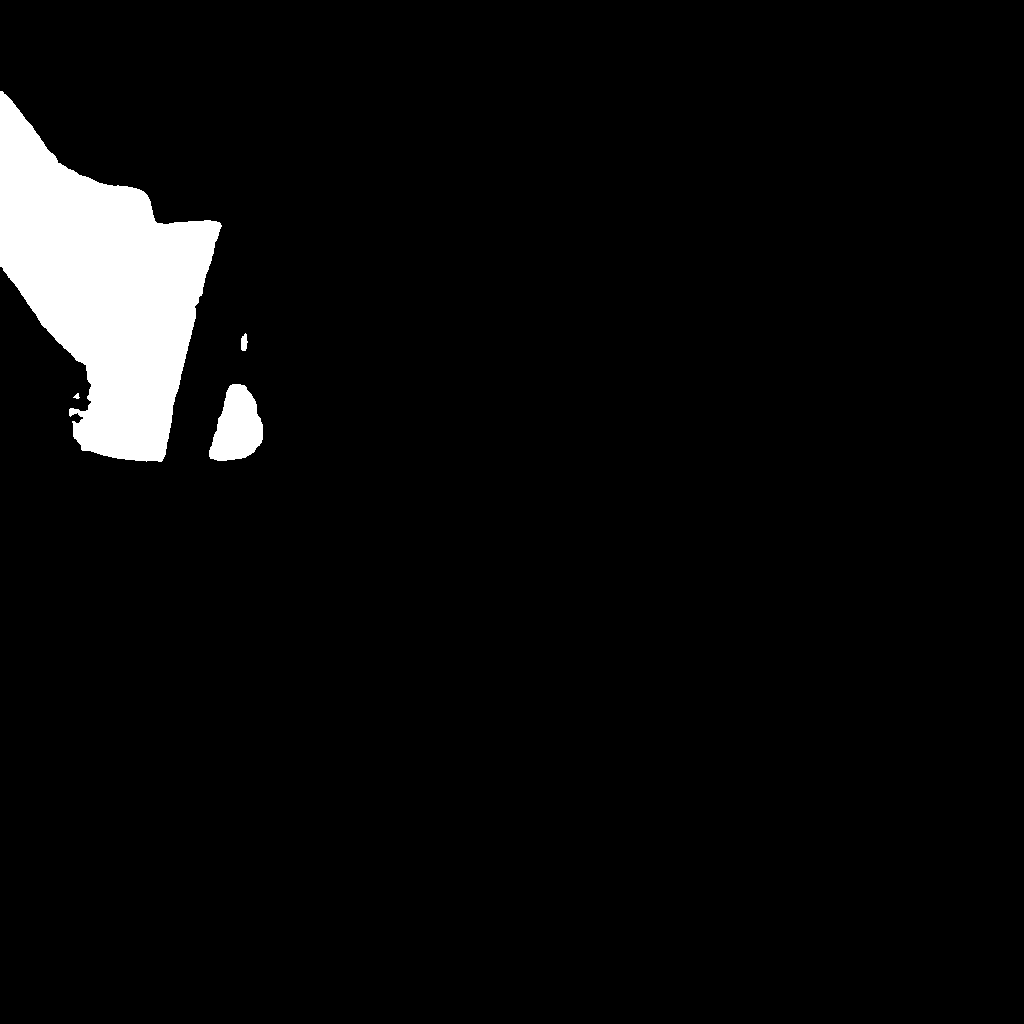

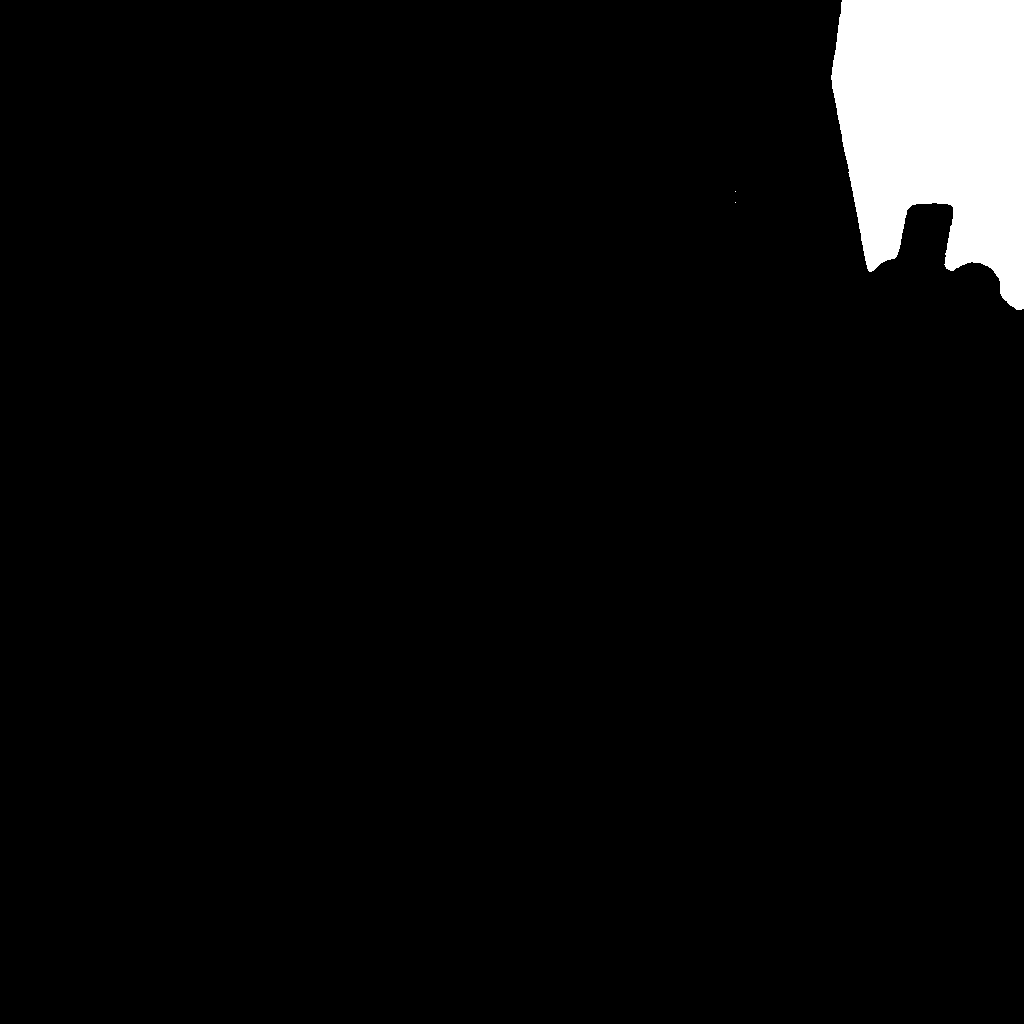

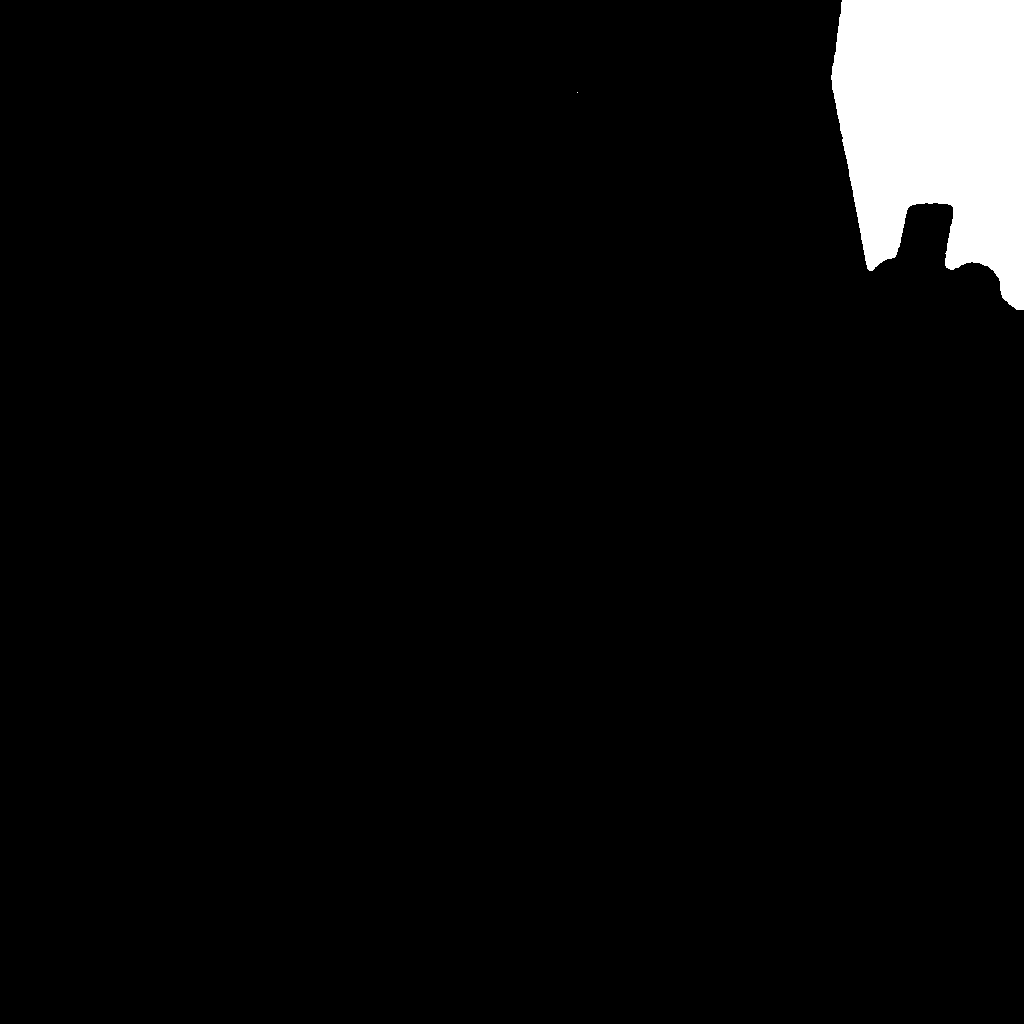

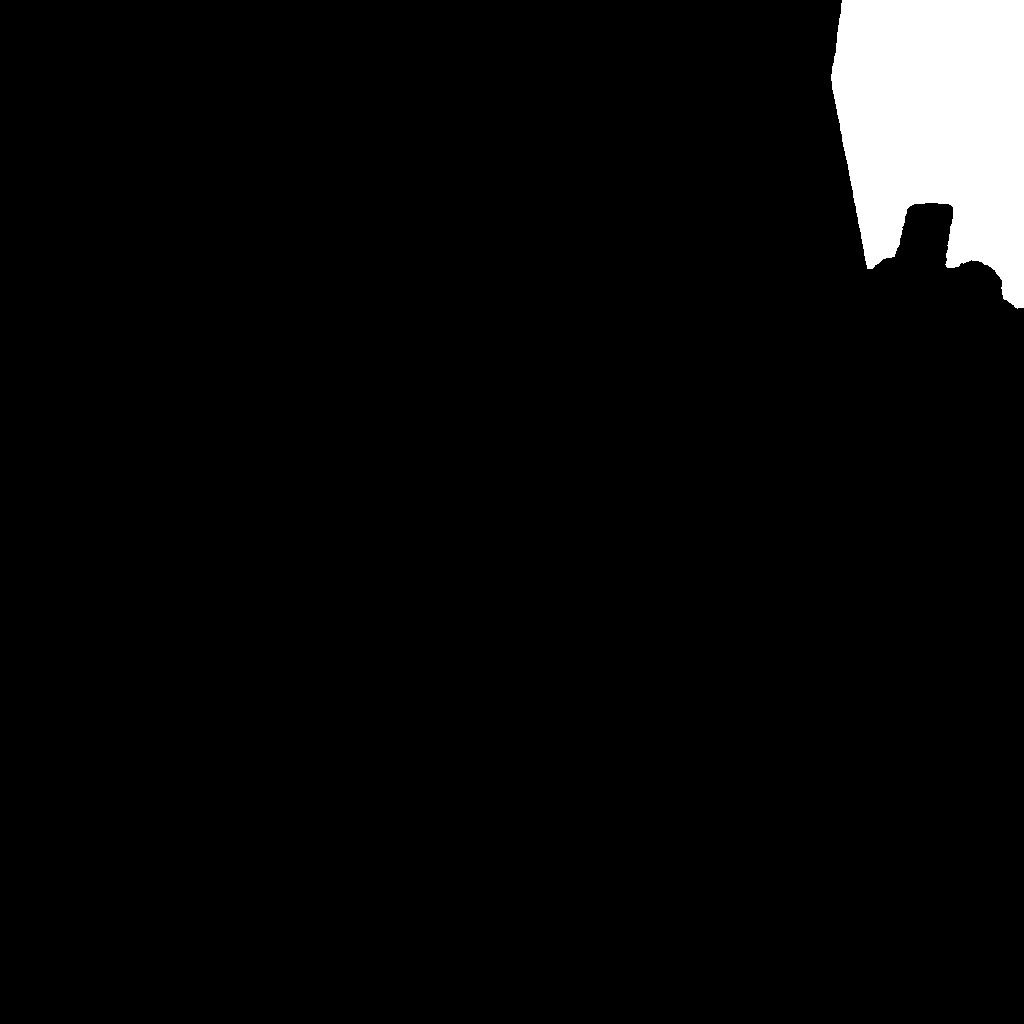

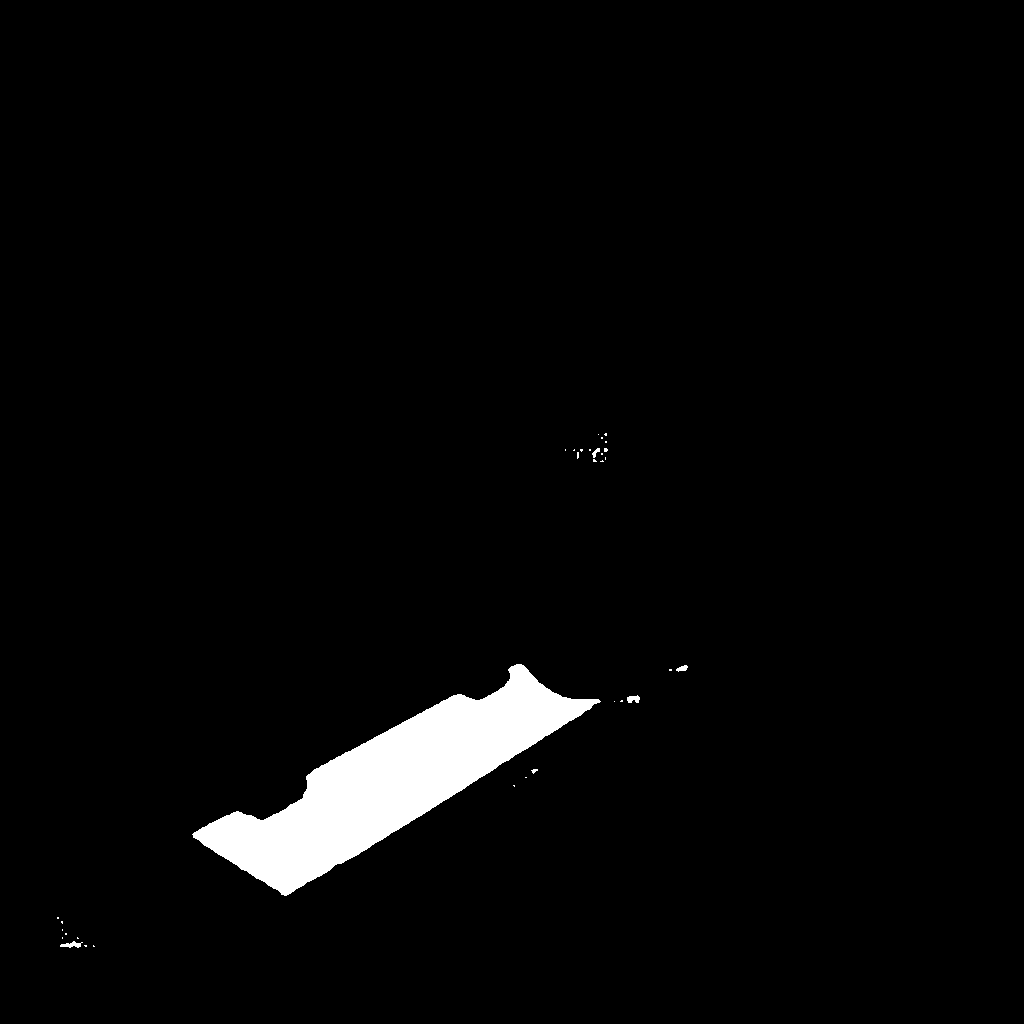

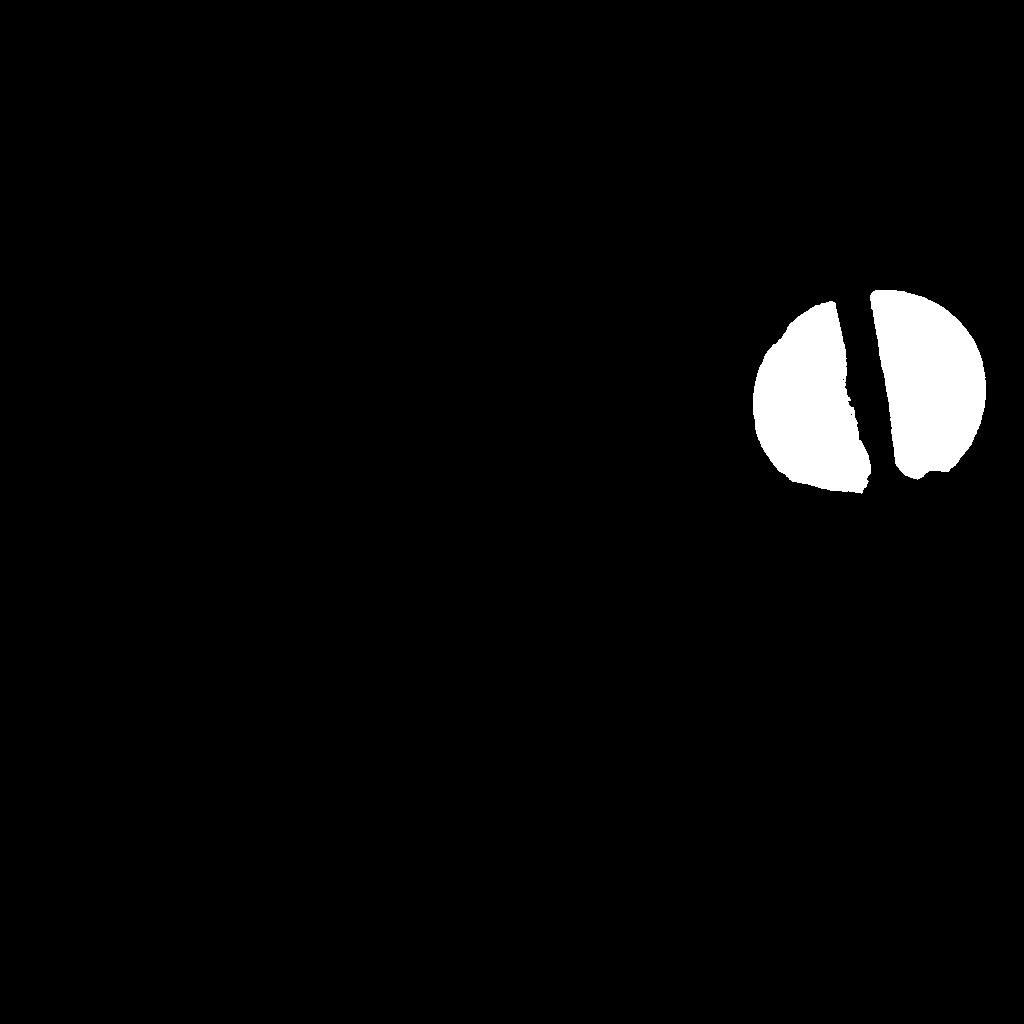

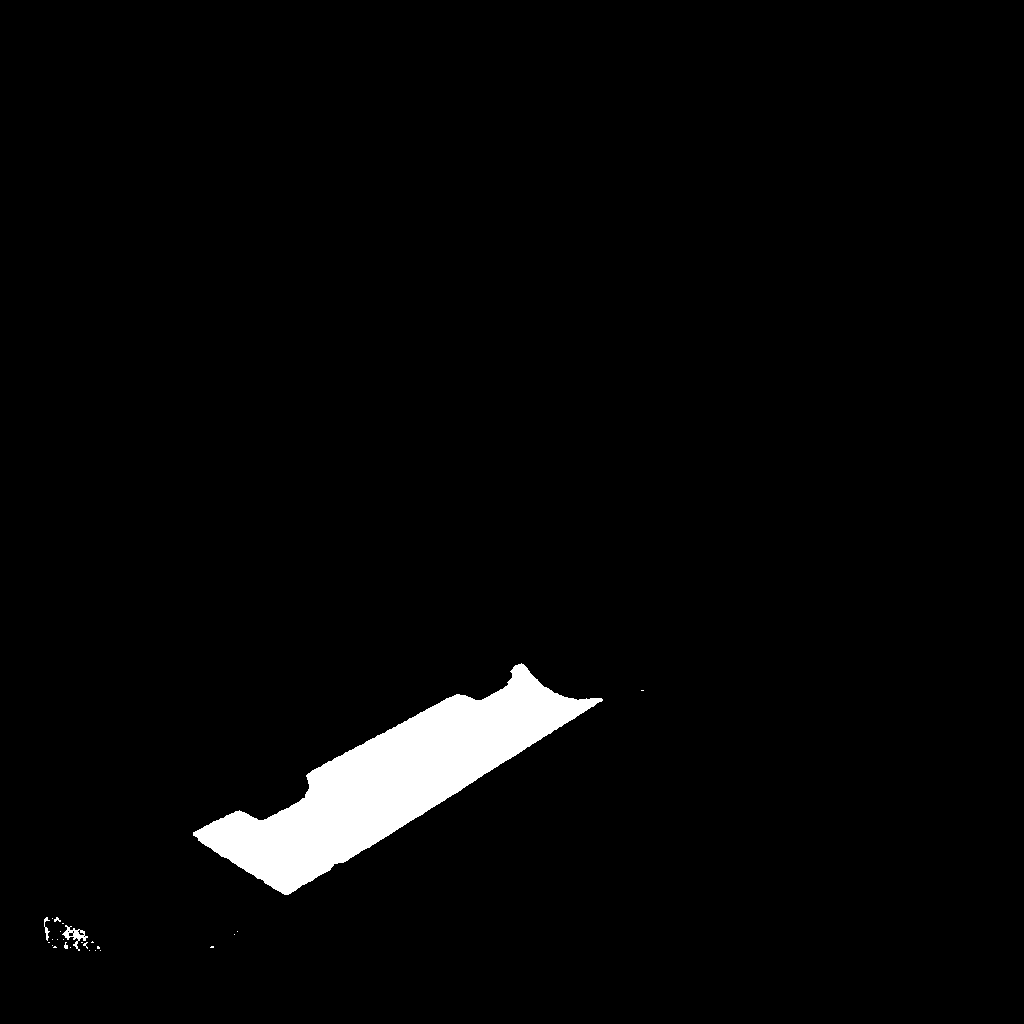

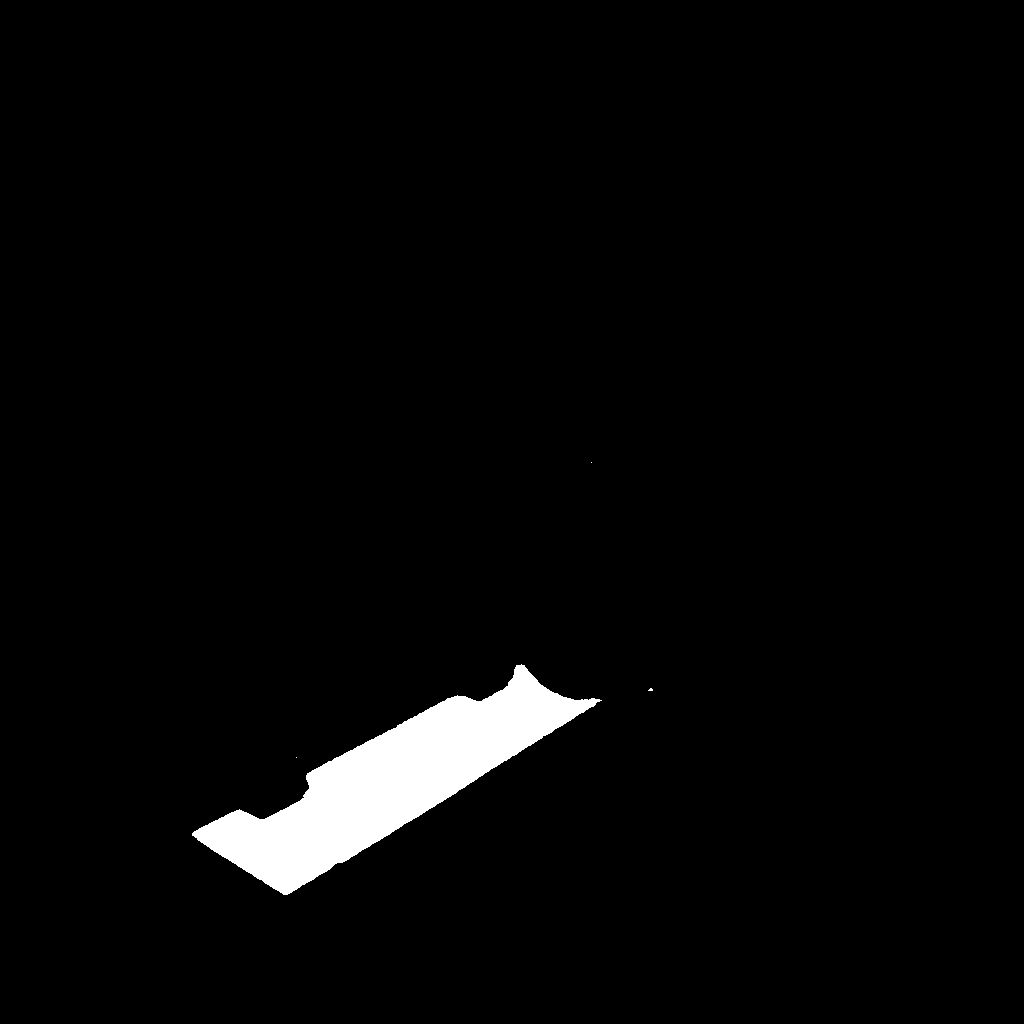

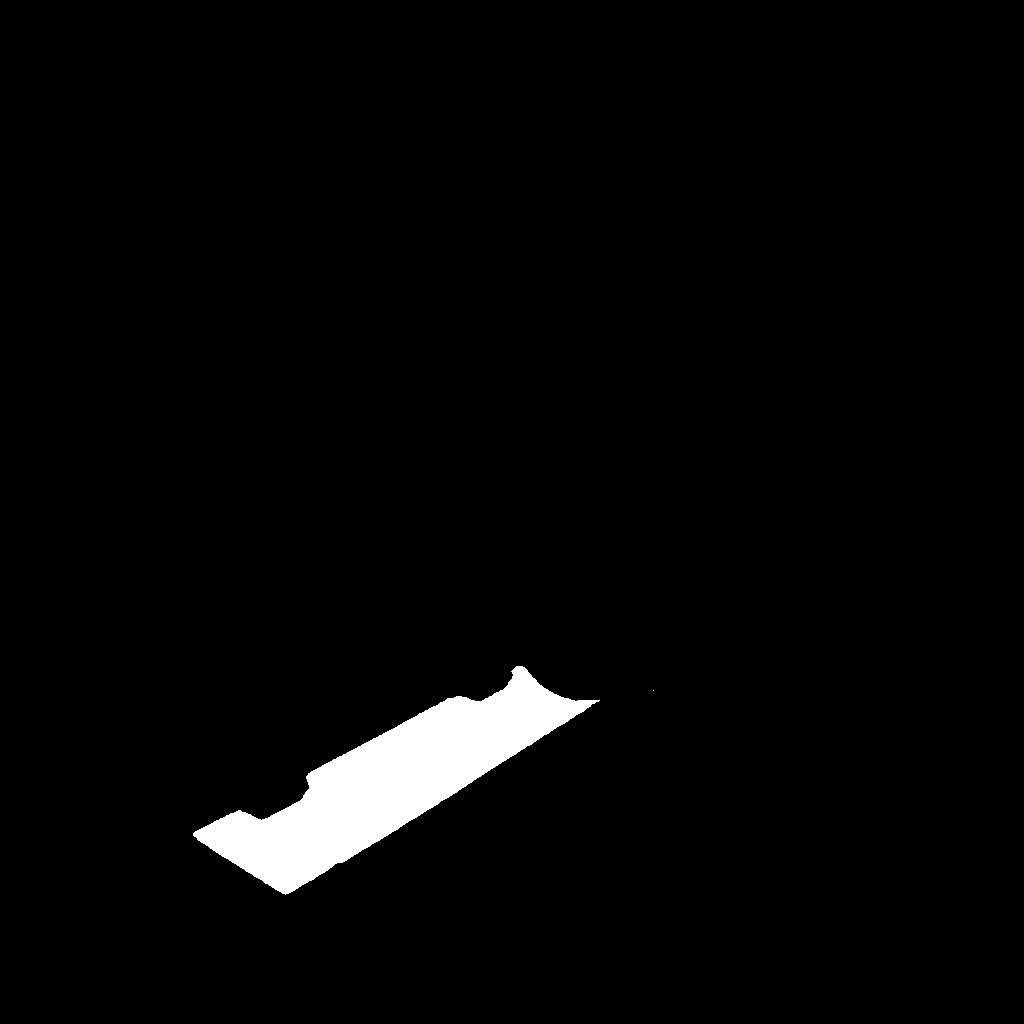

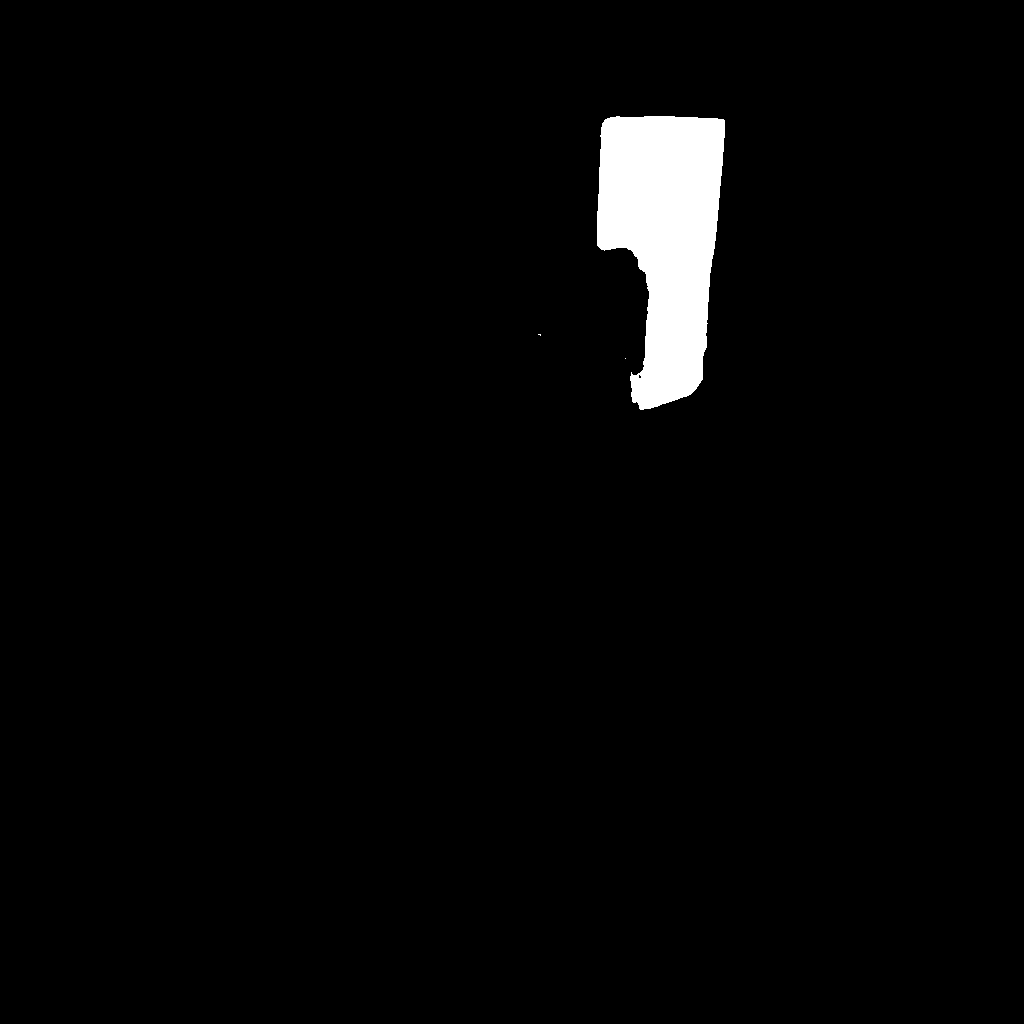

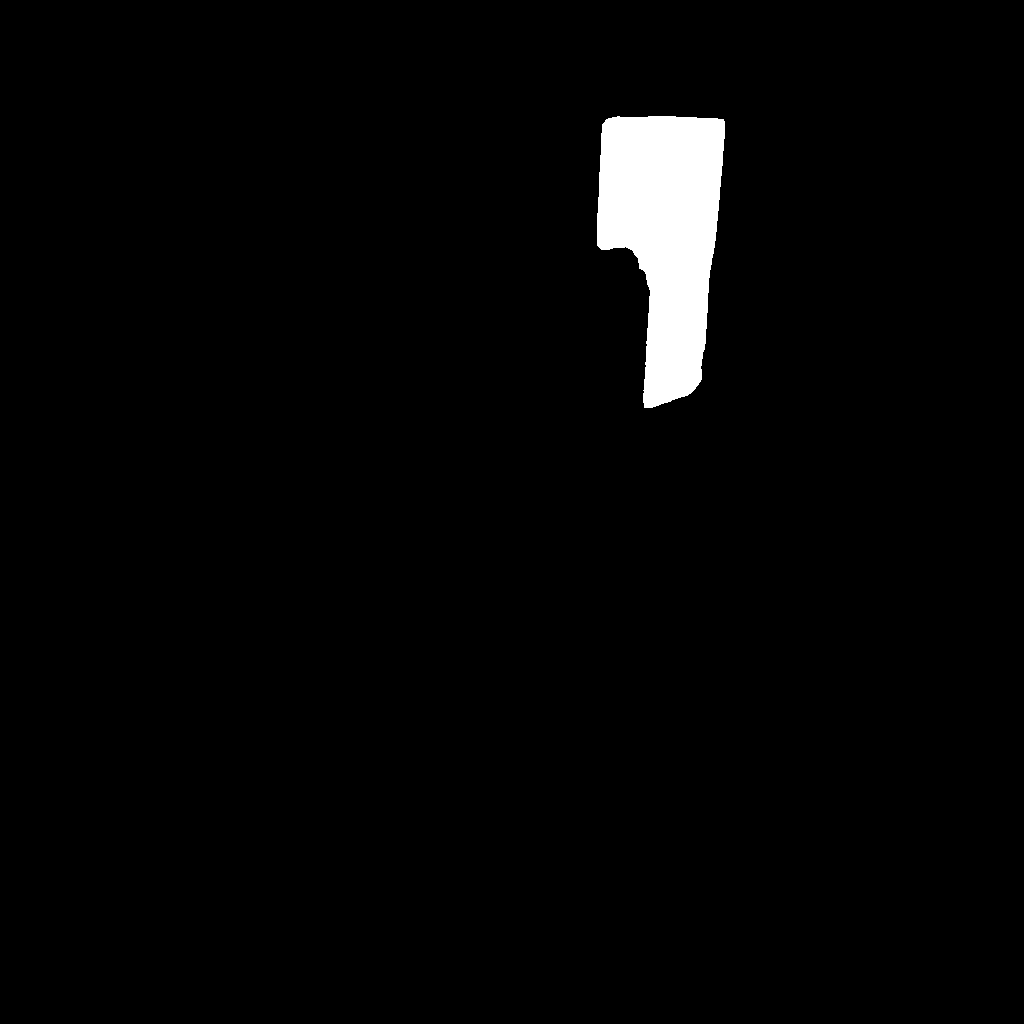

In [32]:
from PIL import Image
import numpy as np

for i, img in enumerate(masks[:16]):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    display(img)  # works in Jupyter or IPython


In [33]:
from skimage.metrics import structural_similarity as ssim

def mask_similarity(mask1, mask2):
    if mask1.ndim == 3:  # Convert RGB to grayscale
        mask1 = mask1.mean(axis=2)
        mask2 = mask2.mean(axis=2)
    mask1 = mask1.astype("float32")
    mask2 = mask2.astype("float32")
    return ssim(mask1, mask2, data_range=mask2.max() - mask2.min())

scores = []

for i, m in enumerate(masks):
    # Resize if necessary
    if m.shape != ref_mask.shape:
        m = np.array(Image.fromarray(m).resize((ref_mask.shape[1], ref_mask.shape[0])))

    score = mask_iou(ref_mask, m)  # or mask_similarity(ref_mask, m)
    scores.append(score)

best_idx = np.argmax(scores)
best_match = masks[best_idx]

print(f"Best matching mask index: {best_idx}, Score: {scores[best_idx]:.4f}")


NameError: name 'ref_mask' is not defined

## Prompting with boxes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
IMAGE_PATH = f"{HOME}/data/dog-2.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

### Interactive box prompt

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
 {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
 {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
 {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}]

**NOTE:** `Sam2ImagePredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format.

In [ ]:
default_box = [
    {'x': 166, 'y': 835, 'width': 99, 'height': 175, 'label': ''},
    {'x': 472, 'y': 885, 'width': 168, 'height': 249, 'label': ''},
    {'x': 359, 'y': 727, 'width': 27, 'height': 155, 'label': ''},
    {'x': 164, 'y': 1044, 'width': 279, 'height': 163, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
boxes = np.array([
    [
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ] for box in boxes
])

### Generate masks with SAM

**NOTE:** Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction. `SAM2ImagePredictor.predict` takes the following arguments:

- `point_coords` - `[np.ndarray or None]` - a `Nx2` array of point prompts to the model. Each point is in `(X,Y)` in pixels.
- `point_labels` - `[np.ndarray or None]` - a length `N` array of labels for the
point prompts. `1` indicates a foreground point and `0` indicates a
background point.
- `box` - `[np.ndarray or None]` - a length `4` array given a box prompt to the
model, in `[x_min, y_min, x_max, y_max]` format.
- `mask_input` - `[np.ndarray]` - a low resolution mask input to the model, typically coming from a previous prediction iteration. Has form `1xHxW`, where
for SAM, `H=W=256`.
- `multimask_output` - `[bool]` - if true, the model will return three masks.
For ambiguous input prompts (such as a single click), this will often
produce better masks than a single prediction. If only a single
mask is needed, the model's predicted quality score can be used
to select the best mask. For non-ambiguous prompts, such as multiple
input prompts, `multimask_output=False` can give better results.
- `return_logits` - `[bool]` - if true, returns un-thresholded masks logits
instead of a binary mask.
- `normalize_coords` - `[bool]` - if true, the point coordinates will be normalized to the range `[0,1]` and point_coords is expected to be wrt. image dimensions.

In [ ]:
predictor.set_image(image_rgb)

masks, scores, logits = predictor.predict(
    box=boxes,
    multimask_output=False
)

# With one box as input, predictor returns masks of shape (1, H, W);
# with N boxes, it returns (N, 1, H, W).
if boxes.shape[0] != 1:
    masks = np.squeeze(masks)


### Results visualisation

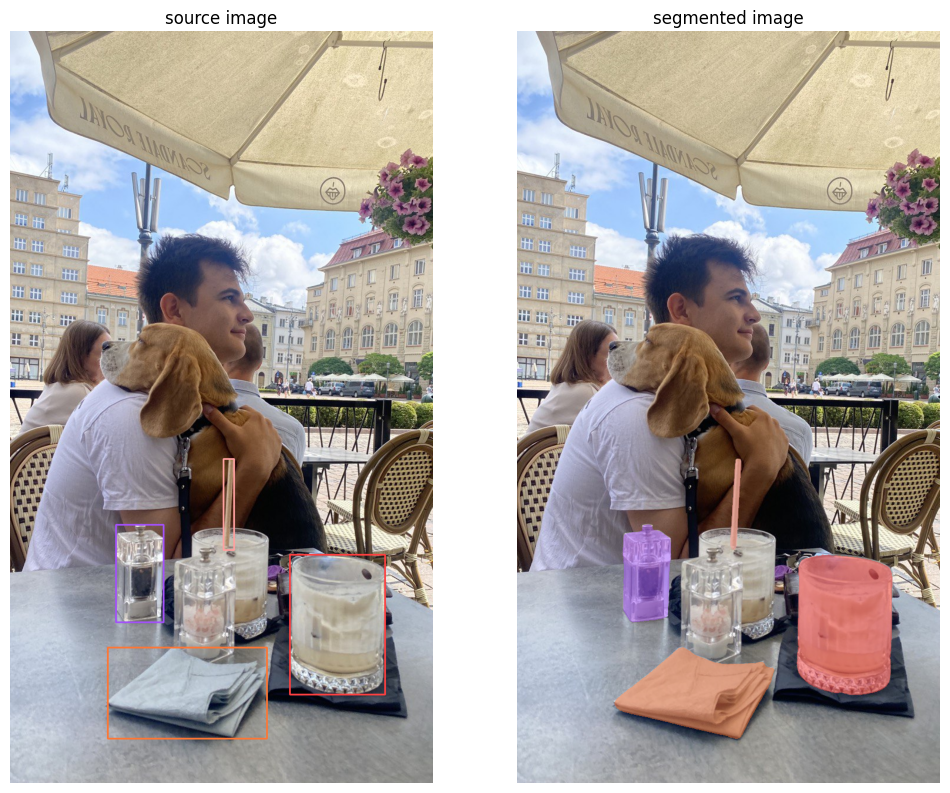

In [ ]:
box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks.astype(bool)
)

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Prompting with points

**NOTE:** Execute cell below and use your mouse to **draw points** on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
 {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
 {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
 {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}]

In [ ]:
default_box = [
    {'x': 330, 'y': 450, 'width': 0, 'height': 0, 'label': ''},
    {'x': 191, 'y': 665, 'width': 0, 'height': 0, 'label': ''},
    {'x': 86, 'y': 879, 'width': 0, 'height': 0, 'label': ''},
    {'x': 425, 'y': 727, 'width': 0, 'height': 0, 'label': ''}
]

boxes = widget.bboxes if widget.bboxes else default_box
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
])
input_label = np.ones(input_point.shape[0])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

**NOTE:** With `multimask_output=True` (the default setting), SAM 2 outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

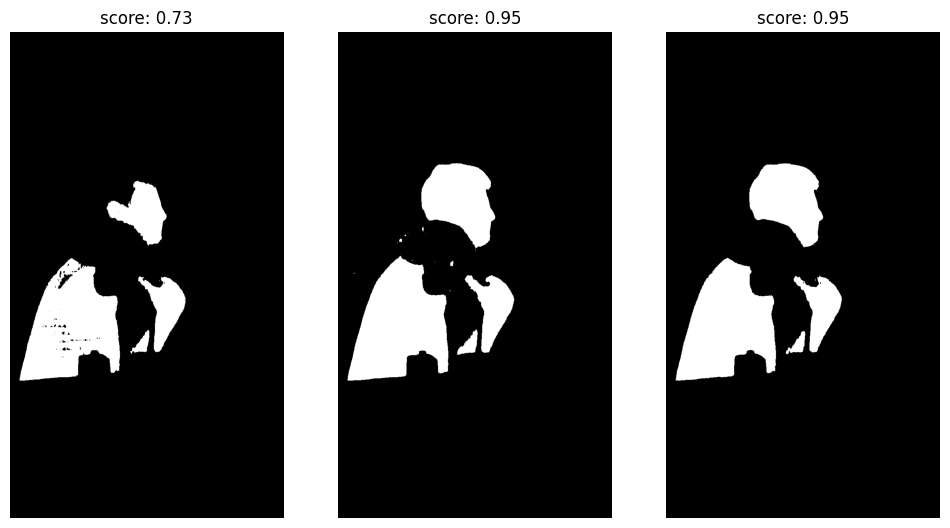

In [ ]:
sv.plot_images_grid(
    images=masks,
    titles=[f"score: {score:.2f}" for score in scores],
    grid_size=(1, 3),
    size=(12, 12)
)